<a href="https://colab.research.google.com/github/NitCoh/TextAnalysisForBigData/blob/master/Big_Data_Analysis_for_Cyber_Security_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
##TODO:
#1. Analysis of the textual features - INSIGHTS
#2. Aggregating the data features
#3. train
#4. cross-validation

In [0]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Initial Data Exploration**

DATA_COLS:
Columns:
FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp

Upload the data file!

In [3]:
COLS = "FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp"
cols_names = COLS.split(",")
cols_names
len(cols_names)

43

In [4]:
## Upload the data file first!
data_path = '/content/Obf_oneInTenWeek1_d1.tsv'

df = pd.read_csv(data_path,sep='\t', names=cols_names)
df.tail(n=6)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205785,7689177,11832730,12791649,14255608,9641,46623,188146,461585,5397947,2720,5644,1036641,221,11713297,9208600,NaN,mediafire.com,download1662.mediafire.com,3072:tf6yptEYKRitLMGYeAyqsR2yE0zx9cXXYuCtylx9e...,9dd7bffeffd5fa9aad965ea7759e6e7d7e97afebfbbbf5...,NaN,1/1/2017 6:55:18 PM,a3f9e1b2-e351-44bf-b946-f1b7d4b5b2db,True,136400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205786,7689196,895354,15999024,3302887,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,33513918,26902010,"1,3,5,21,23,25,31,43,45,46,60,77,106,109,110,1...",zmupload.com,zmupload.com,24576:tGH0BBJjLu4sv6Pmc2N0PhmATlquEF+I5tHzBZcP...,fbf5f66e6f7afa6da7aff99e6bd5a55e9ad6b6a76ed565...,NaN,1/1/2017 10:36:23 PM,9b7c0ca7-db0c-4801-aa84-712584505744,True,1307444,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 10:27:23 PM,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 9:37:46 PM,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 9:03:00 PM,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,1/1/2017 10:00:58 PM,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


In [5]:
df.shape

(205791, 43)

In [0]:
def dump_time(st):
  return st.split()[0] if st.split() else 'NaN'


In [7]:
df.ReportTime = df.ReportTime.apply(dump_time)

df.ReportTime = pd.to_datetime(df.ReportTime)

df_group_by_time = df.groupby(df.ReportTime.dt.day)

df_group_by_time.tail(n=6)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205785,7689177,11832730,12791649,14255608,9641,46623,188146,461585,5397947,2720,5644,1036641,221,11713297,9208600,NaN,mediafire.com,download1662.mediafire.com,3072:tf6yptEYKRitLMGYeAyqsR2yE0zx9cXXYuCtylx9e...,9dd7bffeffd5fa9aad965ea7759e6e7d7e97afebfbbbf5...,NaN,2017-01-01,a3f9e1b2-e351-44bf-b946-f1b7d4b5b2db,True,136400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205786,7689196,895354,15999024,3302887,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,33513918,26902010,"1,3,5,21,23,25,31,43,45,46,60,77,106,109,110,1...",zmupload.com,zmupload.com,24576:tGH0BBJjLu4sv6Pmc2N0PhmATlquEF+I5tHzBZcP...,fbf5f66e6f7afa6da7aff99e6bd5a55e9ad6b6a76ed565...,NaN,2017-01-01,9b7c0ca7-db0c-4801-aa84-712584505744,True,1307444,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,2017-01-01,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


ReportTime
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ReportTime, dtype: object

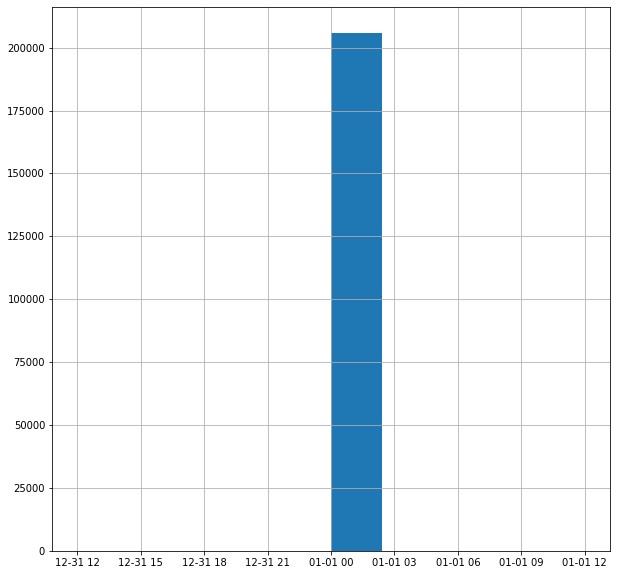

In [8]:


fig = plt.figure(figsize = (10,10))
ax = fig.gca()

df_group_by_time.ReportTime.hist(ax=ax)


In [0]:
# df = df[["FileNameID","Sha1ID","ThreatFamilyID","ThreatNameID","WebFileUrlDomain","WebFileUrlHostname"]]
# df.head(n=6)

Textual features:
FileNameID, WebFuleUrlDomain, WebFileUrlHostname.

***FileNameID:***
This column should be used, because it can indicate couple of things about the file itself.
First, the suffix of the file might imply about the maliciousness of the file, for example, 'exe' files are surely more suspicious, because a malicious code might run while executing those files.
Second, the file name itself can raise the suspicious. Common knowledge from surfing the web indicates that attackers might use well-known software names for their malicious files for example "bsplayer_pro270.1080.exe". (entry number 8 at the dataset)

***WebFileUrlDomain:***
Suspicious domains might lead to rais the probability that the file is malicious, even though attackers sometimes use common well-known domains to upload their files, such as Dropbox, GoogleDrive, MediaFire in order to pass some security checks.

***WebFileUrlHostname***
Sometimes the domain (the network itself) might be non-suspicious, but a machine through this domain (the hostname) can produce a lot of malicious files, for example :
"mediafire.com" and the hostname: "download1507.mediafire.com".
With the cloud storage services today, attackers might hide behind those distributed storage services and the hostname should be considered.

In [10]:
#Filtered data-set

df = df[df.FileNameID.str.isdigit() == False]
df.head(n=30)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
5,bsplayer_free.exe,6879724,67197,6545231,9618,43582,34,778924,14124668,2720,5644,37,1291,10479025,8249640,"1,5,21,23,25,30,45,46,49,51,60,73,84,86,89,90,...",deliverynowsend.com,www.deliverynowsend.com,24576:5QvY1H02hJ/X99M3suMBWom0cOGNrOhR35qjrmKy...,ebd5b97a77eeeab77aeed66b97d56d7adea77a7d7db9a5...,NaN,2017-01-01,413e9be0-4214-4855-bc79-0ad424ca156d,True,1274648,0.0.0.0,APP,7c3b2769a9c1f667aec9e680f2b144b32edc4f4a,d00cfdbf46c98a838bc10dc4e097ae0152c461bc,True,NaN,9e22bfbd,1.0,2,NaN,NaN,unknown,NaN,NaN,NaN,True,NaN,6/19/1992 10:22:17 PM
8,bsplayer_pro270.1080.exe,3501401,7273057,9117642,9641,46623,188146,1037662,878,2720,5644,24632,616,1156079,903060,"0,1,2,3,12,18,23,24,31,33,38,45,46,49,69,84,85...",NaN,canonicalizer.ucsuri.tcs,6144:VzWiPlwflgiNLfEihMcEIi/NfmFwmEV1JTS+co8W3...,6f69bd6f57b5e6b569beda7f7765db6955e6966ffefb75...,NaN,2017-01-01,4dd0ff6b-32b2-4d83-ad75-5cd9131ae6a3,True,402278,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,6/19/1992 10:22:17 PM
9,bsplayer_pro_sa.rar,9001092,5907338,14365028,9641,46623,188146,592096,19654065,2720,5644,1036641,221,13721883,10794560,NaN,cldmail.ru,cloclo28.cldmail.ru,196608:VQI64eTBoDzoQr/7JMvLlndl8LSjfmnnuitty9E...,aa79abbdafebddb5b9feed9f6f659697d77ea7b7ab7efe...,NaN,2017-01-01,7c920f2a-c11f-4ad0-a03e-f8843c0ed771,True,10968324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
14,bspsrc_1.3.21.rar,11353075,17000738,99222,9641,46623,188146,916667,22339856,2720,5644,1036641,221,26669863,21111130,NaN,googleusercontent.com,doc-0o-9k-docs.googleusercontent.com,24576:g1LtKn5Tfdg3QYj8CuY07gVbhi2ZcQhCj4TbRppD...,bb56dfa965aeddffdaae596f569d7fd6bbdaa576ddaf75...,NaN,2017-01-01,4c77a930-e5cb-4953-87b7-552a99661710,True,1339738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
16,bspsrc_1.3.21.rar,11353075,17000738,99222,9641,46623,188146,766653,30813797,2720,5644,1036641,221,12770052,10024740,NaN,therazzerapp.de,therazzerapp.de,24576:g1LtKn5Tfdg3QYj8CuY07gVbhi2ZcQhCj4TbRppD...,bb56dfa965aeddffdaae596f569d7fd6bbdaa576ddaf75...,NaN,2017-01-01,d7ce69d3-2d62-4eb0-8267-783ca785305d,True,1339738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
17,! !§5DarkShooter §3[10k] §5Pack.rar,14658809,6649767,3042011,9641,46623,188146,516414,4884433,2720,5644,1036378,227,20265042,16035890,NaN,mediafire.com,download1120.mediafire.com,196608:6VymlwXn2iFmGNskLKYIwF5D7LXEqUbBJFQIUx7...,bbfffbbbdbdfa6f9575a679d67ffd6699b9dabb5bd96b6...,NaN,2017-01-01,75d9c215-4c67-4e48-b502-840b84b3208b,True,14148736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
18,pcmaster_6.2.1.0_setup_u92.exe,16565404,12034874,18249637,9641,46623,186698,166472,11605396,2720,5644,1036325,628,17210263,13673050,"1,5,21,23,25,43,45,46,60,69,73,77,98,106,109,1...",baidu.com,sw.bos.baidu.com,196608:VV8mZL2xozgMLEAeqXlw5Y3dxj149WyLf8reaZX...,7b6b9aeb67575f6977afedee557ffad9ef7a59baf9af6b...,NaN,2017-01-01,638ff86e-835c-42e6-a60e-75d74e9963f1,True,12770048,6.2.1.0,APP,NaN,NaN,NaN,NaN,00c3615a,1.0,2,NaN,NaN,restricted_sites,NaN,NaN,NaN,True,NaN,9/26/2011 1:21:33 PM
22,MW3.1(1.1.1.86)Installer_IS_rev2.exe,10277180,14374549,2078403,9641,46623,101944,898071,17188825,2720,5644,1036485,632,1738307,1380320,"1,3,5,21,23,25,31,37,45,63,69,73,85,94,106,109...",xkeys.com,xkeys.com,393216:MXuadsUu/aMi4Wq5qsuVqg8wCtKr0XV6dQSNEGa...,bbe6a96f5b6fef56f7feb55be76be55eeda6a6696ae665...,NaN,2017-01-01,757311ba-b151-4a8d-

In [11]:
df.shape

(76088, 43)

In [12]:
# df.ReportTime = df.ReportTime.apply(dump_time)

# df.ReportTime = pd.to_datetime(df.ReportTime)

df_group_by_time = df.groupby(df.ReportTime.dt.day)

df_group_by_time.tail(n=6)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205766,MVC-3.0.exe,11628433,3630493,10349208,9641,46623,103737,873527,8139381,2720,5644,24632,616,1902057,1509690,"1,3,5,21,23,37,45,85,94,98,106,109,110,111,112...",osuosl.org,ftp.osuosl.org,384:iWDyq0z2U5v9RvzQckn8IxfZEiagugoL2RHugIpRTR...,d7e6b97f9f59ddea9b59da6feb5a9a79df665a7bafa669...,NaN,2017-01-01,64653e5a-dbb2-4201-9ae4-eb9692ca7d67,True,20480,3.0.0.0,APP,NaN,NaN,NaN,NaN,00007ab2,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,10/30/2012 9:07:17 PM
205783,"MW2,PC-UnlockAll.rar",6199119,8493487,1922707,9641,46623,188146,516433,4891953,2720,5644,1036641,221,13627459,10725080,NaN,mediafire.com,download1138.mediafire.com,24576:CEl1QnWCPXE9+eCt3FLbzPxysqWd37rSkMubBmDF...,bb66d6aed759b665699dee697a5dba9d5597b6777ed7fa...,NaN,2017-01-01,296b9862-719b-4f4c-9ecb-ce1bff7b4a8e,True,1127190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,2017-01-01,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


ReportTime
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ReportTime, dtype: object

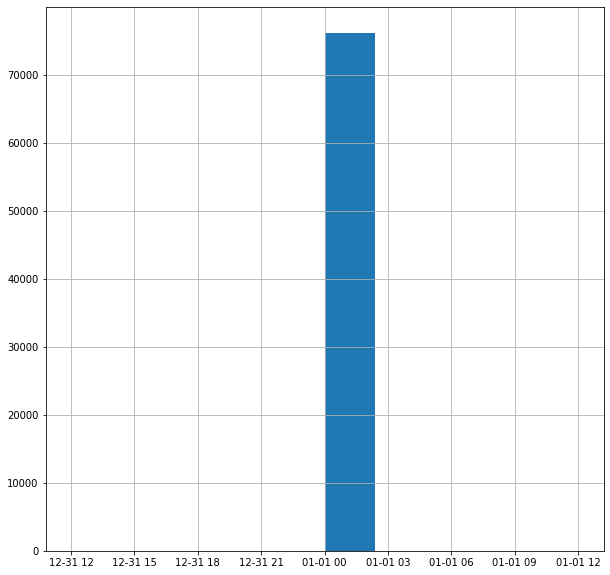

In [13]:
# data.groupby(data.date.dt.year)
# df_group_by_time = df.groupby(df.ReportTime.dt.year)
# df_group_by_time.head(n=6)

# df.ReportTime = df.ReportTime.apply(dump_time)
# df.head(n=3)



fig = plt.figure(figsize = (10,10))
ax = fig.gca()

df_group_by_time.ReportTime.hist(ax=ax)



In [14]:
df.shape

(76088, 43)

In [0]:
def replace_nans(corpus):
  return [w if isinstance(w,str) else '' for w in corpus]


In [16]:
file_names = [x for x in df.FileNameID]
domain_names = replace_nans([x for x in df.WebFileUrlDomain])
hostname_names = replace_nans([x for x in df.WebFileUrlHostname])
len(file_names)
print("Size of file_names : {}, Size of domain_names : {}, Size of hostnames_names: {}".format(len(file_names), len(domain_names), len(hostname_names)))




Size of file_names : 76088, Size of domain_names : 76088, Size of hostnames_names: 76088


In [0]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#file_names is a list of all text entries in the column at the DataFrame.
#Returns - a dense matrix that each row is a n-gram representation of the entries.
def extract_ngrams_as_one_hot(corpus, ngram_size=3,pipeline=None):
  vectorizer = CountVectorizer(ngram_range=(ngram_size, ngram_size), 
                              analyzer='char',preprocessor=pipeline)
    
  X = vectorizer.fit_transform(corpus)
  
  print("------")
  v = vectorizer.transform([corpus[0]]).toarray()
  print(vectorizer.get_feature_names()[:5])
  # print(v)
  return X,vectorizer


def extract_ngrams_as_tf_idf(corpus, ngram_size=3,pipeline=None):
  vectorizer = TfidfVectorizer(ngram_range=(ngram_size, ngram_size), 
                              analyzer='char',preprocessor=pipeline)

  X = vectorizer.fit_transform(corpus)
  
  print("------")
  v = vectorizer.transform([corpus[0]]).toarray()
  print(vectorizer.get_feature_names()[:5])
  # print(v)
  return X,vectorizer


In [18]:
names = ['OMER', 'nit']
little_test_X, vec2 = extract_ngrams_as_tf_idf(names)
print(little_test_X)

print("-----------------")
little_test_X , vec = extract_ngrams_as_one_hot(names)
print(little_test_X.toarray())

print("-----------------")

print(vec.transform(['MER']).toarray())

------
['mer', 'nit', 'ome']
  (0, 0)	0.7071067811865476
  (0, 2)	0.7071067811865476
  (1, 1)	1.0
-----------------
------
['mer', 'nit', 'ome']
[[1 0 1]
 [0 1 0]]
-----------------
[[1 0 0]]


WorkFlow:
The workflow we chose is to aggregate features for each entry in the data set
by iterating through the columns and concatanating text and global features for each entry with the goal of transform it to a wide input vector.
For example, given the corpus ['OMER', 'nit'] considered as a column. 
We exctract 3-grams from it by examine 2 possible representations for each entry within it which will be tested later in the training part:
1. Tf-idf representation of the corpus
2. One-hot representation of the corpus.

# **Text analysis features:**

First for each text feature chosen, we should each entry in the dataset through a pipeline of normalizations before analysis:
1. Removing digits - some files might contain their versions in their names.
2. Casing - for widely conventions we shall use lower-case.
3. Stop words - replacing each stopword with sepcial char in order to increase the reliability of td-idf method.

In [0]:
REMOVE_PUNTS = True
LOWER_CASE = True
REMOVE_DIGITS = True
STOP_WORDS = True
REMOVE_SPACES = True

In [20]:
name = 'bsv3.6.0.550.CN.2899892505.exe'
name2 = 'bsv3.6.0.550.CN.exe	'

#All functions returns string.

#Remove any punctuations
def remove_puncts(corpus):
  return "".join([c for c in corpus if c.isalpha() or c.isdigit()])

#Replace the digits with char 
def replace_digits(corpus, char=''):
  return "".join([char if c.isdigit() else c for c in corpus ])

#Return lower-case string
def lower_case(corpus):
  return corpus.lower()


#Replace each ngram that equals to one of the stop_ngrams with word_to_replace.
def replace_n_grams_stop_ngrams(corpus, stop_ngrams,n=3, word_to_replace=''):
  grams = []
  str_to_ret = ''
  i=n
  while i<=len(corpus):
    if i>=n:
      grama = corpus[i-n:i]
      if grama in stop_ngrams:
        str_to_ret = str_to_ret + word_to_replace
        i = i + 3
      else:
        str_to_ret = str_to_ret + corpus[i-n]    
        i = i + 1
  tail = corpus[i-n:]
  str_to_ret = str_to_ret + tail
  return str_to_ret


print(remove_puncts(name))
print(remove_puncts(name2))


print(replace_n_grams_stop_ngrams("whathatgab3",stop_ngrams=['hat'],n=3))

bsv360550CN2899892505exe
bsv360550CNexe
wgab3


In [0]:
def remove_suffix_of_url(word):
  parts = word.split(".")  
  return ".".join(parts[:-1])

def remove_prefix_of_url(word):
  parts = word.split(".") 
  return ".".join(parts[1:])

In [22]:
print(remove_suffix_of_url("www.google.com"))
print(remove_prefix_of_url("www.google.com"))

www.google
google.com


**Pipeline for filename explanation:**
- remove_puncts - No meaning for punctuation in the filname
- replace_digits - Usually the numbers in the filename indicates the version of a file which has no additional info if we inspect the meaning of the filename.
- lower_case -Lets take a look on an example : BSPLAYER bsplayer BSplayer ---> BSP, bsp , BSp, we would like to treat them as the same n-gram.

**Pipeline for domain explanation:**
- remove_puncts - No meaning for punctuation in the domain
- removing_suffix_of_url - No additional info will be derived from the suffix of the domain (either com, ru, org, etc...)

**Pipeline for hostname explanation:**
- remove_puncts - No meaning for punctuation in the domain
- remove_suffix_of_url - same as domain.
- replace_n_grams_stop_ngrams - replace each of the common stop-words ngrams such as 'www'.


In [0]:
# Explanation above.
def pipeline_for_filename(word): 
  word = remove_puncts(word) 
  word = replace_digits(word)
  word = lower_case(word) 
  return word

def pipeline_for_domain(word):
  word = remove_suffix_of_url(word)
  word = remove_puncts(word)
  return word

def pipeline_for_hostname(word):
  stop_words = ['www'] #Consider add more common prefix
  word = remove_suffix_of_url(word)
  word = replace_n_grams_stop_ngrams(word, stop_words)
  word = remove_puncts(word)
  return word


In [24]:
print("before")
print(domain_names[:5])
print([remove_suffix_of_url(w) for w in domain_names][:5])

before
['deliverynowsend.com', '', 'cldmail.ru', 'googleusercontent.com', 'therazzerapp.de']
['deliverynowsend', '', 'cldmail', 'googleusercontent', 'therazzerapp']


In [25]:
def print_example(input):
  chopped = input[:5]
  print("Before:")
  print(chopped)
  print("After:")
  print([pipeline_for_filename(w) for w in chopped])

print_example(file_names)
print_example(domain_names)
print_example(hostname_names)

Before:
['bsplayer_free.exe', 'bsplayer_pro270.1080.exe', 'bsplayer_pro_sa.rar', 'bspsrc_1.3.21.rar', 'bspsrc_1.3.21.rar']
After:
['bsplayerfreeexe', 'bsplayerproexe', 'bsplayerprosarar', 'bspsrcrar', 'bspsrcrar']
Before:
['deliverynowsend.com', '', 'cldmail.ru', 'googleusercontent.com', 'therazzerapp.de']
After:
['deliverynowsendcom', '', 'cldmailru', 'googleusercontentcom', 'therazzerappde']
Before:
['www.deliverynowsend.com', 'canonicalizer.ucsuri.tcs', 'cloclo28.cldmail.ru', 'doc-0o-9k-docs.googleusercontent.com', 'therazzerapp.de']
After:
['wwwdeliverynowsendcom', 'canonicalizerucsuritcs', 'cloclocldmailru', 'docokdocsgoogleusercontentcom', 'therazzerappde']


In [0]:
from scipy.sparse import coo_matrix, hstack

def generate_text_features_matrices(df):
  """
  Returns: 
  - Number of distinct 3-grams for filename,domain-names,host-names
  - 2 different encoded (One-hot,tf-idf) matrices.
  Each matrix her rows are the entries in the df and her columns are the
  concatanation of the text-features extracted from each corpus we have chosen.
  """
  file_names = [x for x in df.FileNameID]
  domain_names = replace_nans([x for x in df.WebFileUrlDomain])
  hostname_names = replace_nans([x for x in df.WebFileUrlHostname])

  def agg(func,corpus,extractor):
    X,vectorizer = extractor(corpus,pipeline=func)
    return X,vectorizer


  one_hot_mat_for_file_name, vec_file_name_one_hot = agg(pipeline_for_filename,file_names,extract_ngrams_as_one_hot)
  one_hot_mat_for_domain, vec_domain_one_hot = agg(pipeline_for_domain,domain_names,extract_ngrams_as_one_hot)
  one_hot_mat_for_hostname, vec_hostname_one_hot = agg(pipeline_for_hostname,hostname_names,extract_ngrams_as_one_hot)

  print("Shapes:")
  print("one_hot_mat_for_file_name: {}".format(one_hot_mat_for_file_name.shape))
  print("one_hot_mat_for_domain: {}".format(one_hot_mat_for_domain.shape))
  print("one_hot_mat_for_hostname: {}".format(one_hot_mat_for_hostname.shape))

  tfidf_mat_for_file_name, vec_file_name_tfidf = agg(pipeline_for_filename,file_names,extract_ngrams_as_tf_idf)
  tfidf_mat_for_domain, vec_domain_tfidf = agg(pipeline_for_domain,domain_names,extract_ngrams_as_tf_idf)
  tfidf_mat_for_hostname, vec_hostname_tfidf = agg(pipeline_for_hostname,hostname_names,extract_ngrams_as_tf_idf)

  print("--------")

  print("Shapes:")
  print("tfidf_mat_for_file_name: {}".format(tfidf_mat_for_file_name.shape))
  print("tfidf_mat_for_domain: {}".format(tfidf_mat_for_domain.shape))
  print("tfidf_mat_for_hostname: {}".format(tfidf_mat_for_hostname.shape))

  one_hot_mat_text_features = hstack([one_hot_mat_for_file_name,one_hot_mat_for_domain,one_hot_mat_for_hostname])

  tfidf_mat_text_features = hstack([tfidf_mat_for_file_name,tfidf_mat_for_domain,tfidf_mat_for_hostname])

  tfidf_vectorizers = {
      "fn": vec_file_name_tfidf,
      "dn": vec_domain_tfidf,
      "hn": vec_hostname_tfidf
  }

  one_hot_vectorizers = {
      "fn": vec_file_name_one_hot,
      "dn": vec_domain_one_hot,
      "hn": vec_hostname_one_hot
  }


  print("--------")

  print("Total shapes:")
  print("one_hot_mat_text_features: {}".format(one_hot_mat_text_features.shape))
  print("tfidf_mat_text_features: {}".format(tfidf_mat_text_features.shape))

  distinct_n_grams = {"fn": one_hot_mat_for_file_name.shape[1],
                      "dn": one_hot_mat_for_domain.shape[1],
                      "hn": one_hot_mat_for_hostname.shape[1]}  

  return distinct_n_grams,one_hot_mat_text_features,tfidf_mat_text_features,tfidf_vectorizers, one_hot_vectorizers

In [0]:
from sklearn.preprocessing import normalize

def extract_normalize_feature(df,column_name):
  x = df[column_name].values #returns a numpy array
  x_scaled = (x - x.min()) / (x.max() - x.min())
  return x_scaled


In [28]:
x_scaled = extract_normalize_feature(df,"ThreatNameID")
x_scaled[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Aggregating the data:
Some files might appear on few entries in the dataset, using the sha1ID,
we can recongize them along the dataset and extract a list of names which this file was known for.

# **Splitting the data-set into train,test randomly:**

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [30]:
train.head(2)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
68055,RobloxPlayerLauncher (4).exe,11792565,5741248,2862513,9475,38489,111697,515448,30532349,2720,5644,1036325,628,33269382,26716720,"1,5,21,23,25,37,45,46,49,63,69,73,85,89,94,98,...",rbxcdn.com,setup.rbxcdn.com,12288:6Yms52lqW25iK8sTqm+8GDoocqjZjlNXiTsLeixS...,bbf6a5be9fdeb96bd6b9a55e979af55d7f99556e5f76a9...,NaN,2017-01-01,95c33470-d5f2-4fc5-a264-7db4e5db25fe,True,1110072,1.6.3.32426,APP,b22088de0d6793f431f822749d4712cb47b20024,5b8f88c80a73d35f76cd412a9e74e916594dfa67,True,NaN,001160d2,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/9/2016 5:33:37 AM
32263,foobar2000_v1.3.14.exe,8467351,7321602,9311075,9641,46623,159855,986561,14457444,2720,5644,1036485,632,9293265,7320440,"1,3,5,21,23,25,31,45,46,60,89,106,109,110,111,...",foobar2000.org,www.foobar2000.org,98304:yEej6BW6D3dSqZk6gyH+eSzChcIE4UT1VY5nh7/x...,bbda977f5f665a7da75a557abaf9b5f9ad966f679d96fb...,NaN,2017-01-01,9bdc70e9-244a-4125-b73a-72bb19528006,True,3958405,1.3.14.0,APP,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/11/2016 9:50:48 PM


In [0]:
# Train : the dataframe that is used to determine which files are clean and which are malicious
#is the dataframe itself of the train.
#Test : the dataframe that is used to determine which files are clean and which malicious
#is the the whole dataset.

sha1_for_train = train.Sha1ID.value_counts()
sha1_for_test = df.Sha1ID.value_counts()

d_sha1_for_train = dict(sha1_for_train)
d_sha1_for_test = dict(sha1_for_test)


In [0]:
#Lets define : Sha1Counter(dict of sha1 - how many times it appeared) in a given dataframe.
#Input : Given a group of examples known as the data frame.
#Output: Sha1Counter for cleans , Sha1Counter for malicious, list of labels for a given data frame.
def split_to_clean_and_mal(sha1_dict,df,threshold=100):
  sha1_clean = []
  sha1_mal = []
  for k,v in sha1_dict.items():
    if v > threshold:
      sha1_clean.append(k)
    else:
      sha1_mal.append(k)

  Y = []
  df_clean = pd.DataFrame()
  df_malicious = pd.DataFrame()
  for i,(ind,row) in enumerate(df.iterrows()):
    sha1 = df.Sha1ID[ind]
    if sha1_dict[sha1] > threshold:
      Y.append(0)
    elif sha1_dict[sha1] <= threshold:
      Y.append(1)

  return df[df.Sha1ID.isin(sha1_clean)],df[df.Sha1ID.isin(sha1_mal)],Y

### **Tagging the data-set with malicious and clean (threshold=100):**

In [33]:
train_df_clean,train_df_mal,Y_train = split_to_clean_and_mal(d_sha1_for_train,train)

test_df_clean,test_df_mal,Y_test = split_to_clean_and_mal(d_sha1_for_test,test)

train_counted_clean_f = train_df_clean.shape[0]
train_counted_malicious_f = train_df_mal.shape[0]
test_counted_clean_f = test_df_clean.shape[0]
test_counted_malicious_f = test_df_mal.shape[0]


print("-----------------Train---------------------")

print("Based on train only : Number of clean files: {} , Number of malicious files: {}".format(train_counted_clean_f,train_counted_malicious_f))

print("-----------------Test---------------------")

print("Based of train+test : Number of clean files: {} , Number of malicious files: {}".format(test_counted_clean_f,test_counted_malicious_f))

print("-------------------------------------------")

print("Counted labeled examples in train : {}".format(len(Y_train)))
print("Counted labeled examples in test : {}".format(len(Y_test)))


-----------------Train---------------------
Based on train only : Number of clean files: 10286 , Number of malicious files: 50584
-----------------Test---------------------
Based of train+test : Number of clean files: 3107 , Number of malicious files: 12111
-------------------------------------------
Counted labeled examples in train : 60870
Counted labeled examples in test : 15218


In [0]:
train_df_clean_400_thresh,train_df_mal_400_thresh,Y_train_400_thresh = split_to_clean_and_mal(d_sha1_for_train,train,threshold=400)

In [0]:
test_df_clean_400_thresh,test_df_mal_400_thresh,Y_test_400_thresh = split_to_clean_and_mal(d_sha1_for_test,test,threshold=400)

# **Textual features analysis:**
We present few statistics of the whole data-set after filtering.

In [36]:
total_distinct_n_grams,_,_,_,_ = generate_text_features_matrices(df)

------
['aaa', 'aab', 'aac', 'aad', 'aae']
------
['000', '001', '002', '00c', '00d']
------
['000', '001', '002', '003', '004']
Shapes:
one_hot_mat_for_file_name: (76088, 12750)
one_hot_mat_for_domain: (76088, 7097)
one_hot_mat_for_hostname: (76088, 13697)
------
['aaa', 'aab', 'aac', 'aad', 'aae']
------
['000', '001', '002', '00c', '00d']
------
['000', '001', '002', '003', '004']
--------
Shapes:
tfidf_mat_for_file_name: (76088, 12750)
tfidf_mat_for_domain: (76088, 7097)
tfidf_mat_for_hostname: (76088, 13697)
--------
Total shapes:
one_hot_mat_text_features: (76088, 33544)
tfidf_mat_text_features: (76088, 33544)


In [37]:

print("Number of distinct 3-grams in the corpus of the file-name : {}".format(total_distinct_n_grams["fn"]))
print("Number of distinct 3-grams in the corpus of the domain-names : {}".format(total_distinct_n_grams["dn"]))
print("Number of distinct 3-grams in the corpus of the host-names : {}".format(total_distinct_n_grams["hn"]))

Number of distinct 3-grams in the corpus of the file-name : 12750
Number of distinct 3-grams in the corpus of the domain-names : 7097
Number of distinct 3-grams in the corpus of the host-names : 13697


In [0]:

from collections import Counter
import statistics 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict



def plot_counter(cr):
  labels, values = zip(*cr.items())

  indexes = np.arange(len(labels))
  width = 1
  plt.figure(figsize=(70,5))
  plt.bar(indexes, values, width)
  plt.xticks(indexes + width * 0.5, labels)
  plt.show()

def print_statistics_per_df(df,graphs=False):
  file_names = [x for x in df.FileNameID]
  domain_names = replace_nans([x for x in df.WebFileUrlDomain])
  hostname_names = replace_nans([x for x in df.WebFileUrlHostname])

  file_names_after_pipeline = [pipeline_for_filename(x) for x in file_names]
  domain_names_after_pipeline = [pipeline_for_domain(x) for x in domain_names]
  hostname_names_after_pipeline = [pipeline_for_hostname(x) for x in hostname_names]


  fn_c = Counter(file_names_after_pipeline)
  dn_c = Counter(domain_names_after_pipeline)
  hn_c = Counter(hostname_names_after_pipeline)

  print("Number of distinct file-names after pipeline : {}".format(len(fn_c.keys())))
  print("Number of distinct domain-names after pipeline : {}".format(len(dn_c.keys())))
  print("Number of distinct hostname-names after pipeline : {}".format(len(hn_c.keys())))

  print("-------------------------------------------------------")
  print("Average number of repetative file-names after pipeline : {}".format(statistics.mean(fn_c.values())))
  print("Average number of repetative domain-names after pipeline : {}".format(statistics.mean(dn_c.values())))
  print("Average number of repetative hostname-names after pipeline : {}".format(statistics.mean(hn_c.values())))


  print("-------------------------------------------------------")
  print("Median number of repetative file-names after pipeline : {}".format(statistics.median(fn_c.values())))
  print("Median number of repetative domain-names after pipeline : {}".format(statistics.median(dn_c.values())))
  print("Median number of repetative hostname-names after pipeline : {}".format(statistics.median(hn_c.values())))

  print("-------------------------------------------------------")


  sha1s = [x for x in df.Sha1ID]
  fn_to_sha1 = {k:v for (k,v) in zip(file_names,sha1s)}
  sha1_distinct = Counter(fn_to_sha1.values())

  fn_to_how_many_times_it_appeared = {k:sha1_distinct[v] for (k,v) in fn_to_sha1.items()}

  print("Average number of appearances for each file-name according to the sha1 : {}".format(statistics.mean(fn_to_how_many_times_it_appeared.values())))
  print("Median number of appearances for each file-name according to the sha1 : {}".format(statistics.median(fn_to_how_many_times_it_appeared.values())))


  if graphs:
    plot_counter(fn_c)
    plot_counter(dn_c)
    plot_counter(hn_c)
    

In [0]:
######Just tools


def check_suffix_of_files_dist(df):
  file_names = [x.split(".")[-1] for x in df.FileNameID]
  print(len(file_names))
  print(df.shape)
  return Counter(file_names), {k: (v/df.shape[0])*100 for (k,v) in sorted(Counter(file_names).items(), key=lambda item: item[1], reverse=True)}

def print_stats_for_given_columns(df):
  domain_names = [pipeline_for_domain(y) for y in replace_nans([x for x in df.WebFileUrlDomain])]
  sha1s = [x for x in df.Sha1ID]
  if len(domain_names) != len(sha1s):
    print("length error")
  else:
    mapper = defaultdict(list)
    for k, v in zip(domain_names,sha1s):
      mapper[k].append(v)
    
    print(mapper)
    
    return {k:len(Counter(v).values()) for (k,v) in mapper.items()}

In [40]:
print_statistics_per_df(df)

Number of distinct file-names after pipeline : 14775
Number of distinct domain-names after pipeline : 5513
Number of distinct hostname-names after pipeline : 8920
-------------------------------------------------------
Average number of repetative file-names after pipeline : 5.149780033840948
Average number of repetative domain-names after pipeline : 13.801559949210956
Average number of repetative hostname-names after pipeline : 8.530044843049327
-------------------------------------------------------
Median number of repetative file-names after pipeline : 1
Median number of repetative domain-names after pipeline : 2
Median number of repetative hostname-names after pipeline : 2.0
-------------------------------------------------------
Average number of appearances for each file-name according to the sha1 : 1.7676733592036444
Median number of appearances for each file-name according to the sha1 : 1


### **Statistics of the train data-set with tagging clean-malicious with threshold=100:**

1.

In [41]:
print("Size of train_df_clean : {}".format(train_df_clean.shape))
print_statistics_per_df(train_df_clean)

Size of train_df_clean : (10286, 43)
Number of distinct file-names after pipeline : 167
Number of distinct domain-names after pipeline : 98
Number of distinct hostname-names after pipeline : 249
-------------------------------------------------------
Average number of repetative file-names after pipeline : 61.59281437125748
Average number of repetative domain-names after pipeline : 104.95918367346938
Average number of repetative hostname-names after pipeline : 41.30923694779116
-------------------------------------------------------
Median number of repetative file-names after pipeline : 4
Median number of repetative domain-names after pipeline : 7.0
Median number of repetative hostname-names after pipeline : 2
-------------------------------------------------------
Average number of appearances for each file-name according to the sha1 : 22.210843373493976
Median number of appearances for each file-name according to the sha1 : 27.0


2.

In [42]:
print("Size of train_df_mal : {}".format(train_df_mal.shape))
print_statistics_per_df(train_df_mal)

Size of train_df_mal : (50584, 43)
Number of distinct file-names after pipeline : 13146
Number of distinct domain-names after pipeline : 4978
Number of distinct hostname-names after pipeline : 7934
-------------------------------------------------------
Average number of repetative file-names after pipeline : 3.8478624676707742
Average number of repetative domain-names after pipeline : 10.161510646846123
Average number of repetative hostname-names after pipeline : 6.375598689185782
-------------------------------------------------------
Median number of repetative file-names after pipeline : 1.0
Median number of repetative domain-names after pipeline : 2.0
Median number of repetative hostname-names after pipeline : 1.0
-------------------------------------------------------
Average number of appearances for each file-name according to the sha1 : 1.499072237507198
Median number of appearances for each file-name according to the sha1 : 1


### **Statistics of the train data-set with tagging clean-malicious with threshold=400:**

3.

Size of train_df_clean_400_thresh : (3621, 43)
Number of distinct file-names after pipeline : 8
Number of distinct domain-names after pipeline : 7
Number of distinct hostname-names after pipeline : 54
-------------------------------------------------------
Average number of repetative file-names after pipeline : 452.625
Average number of repetative domain-names after pipeline : 517.2857142857143
Average number of repetative hostname-names after pipeline : 67.05555555555556
-------------------------------------------------------
Median number of repetative file-names after pipeline : 398.0
Median number of repetative domain-names after pipeline : 123
Median number of repetative hostname-names after pipeline : 8.0
-------------------------------------------------------
Average number of appearances for each file-name according to the sha1 : 32.83561643835616
Median number of appearances for each file-name according to the sha1 : 34


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27963 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20855 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23090 missing from current font.
  font.set_

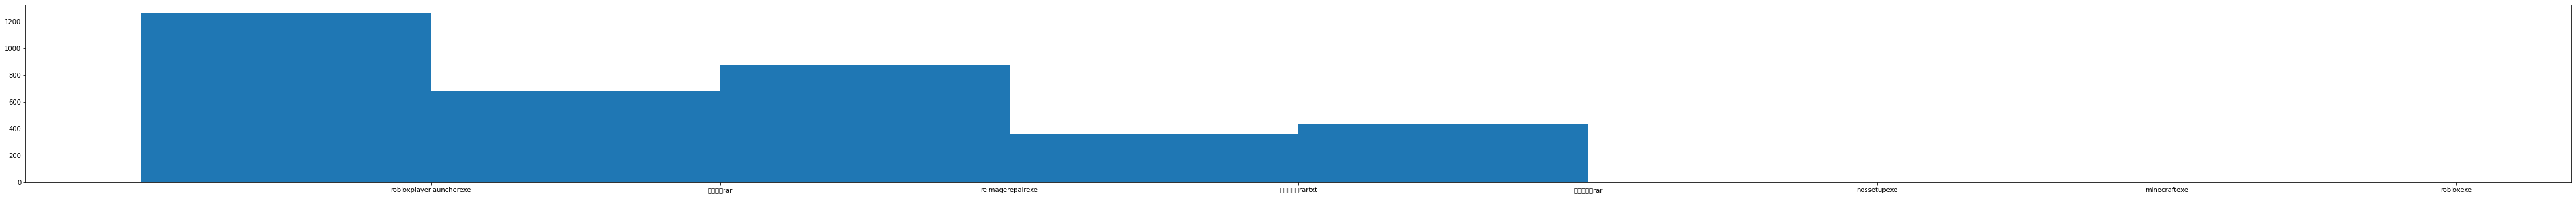

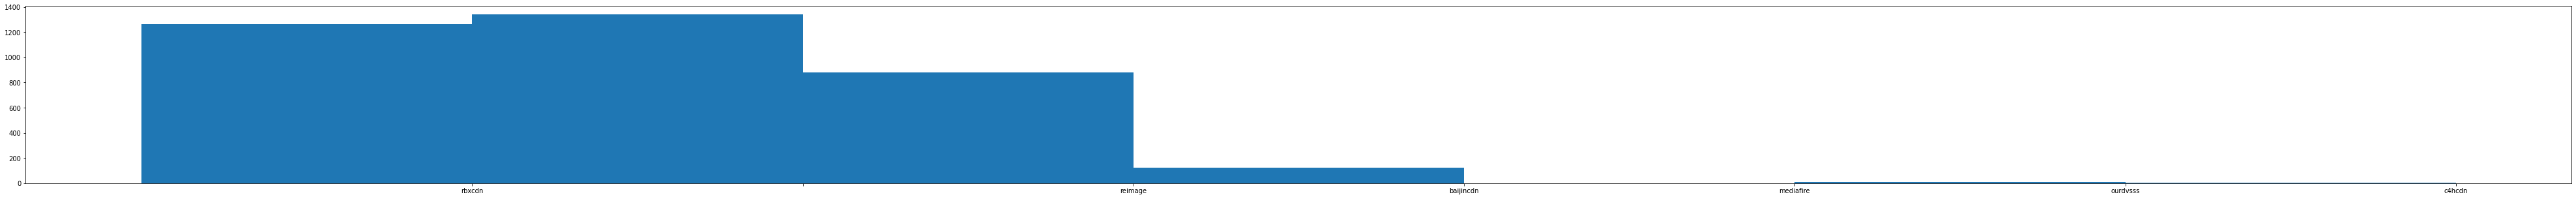

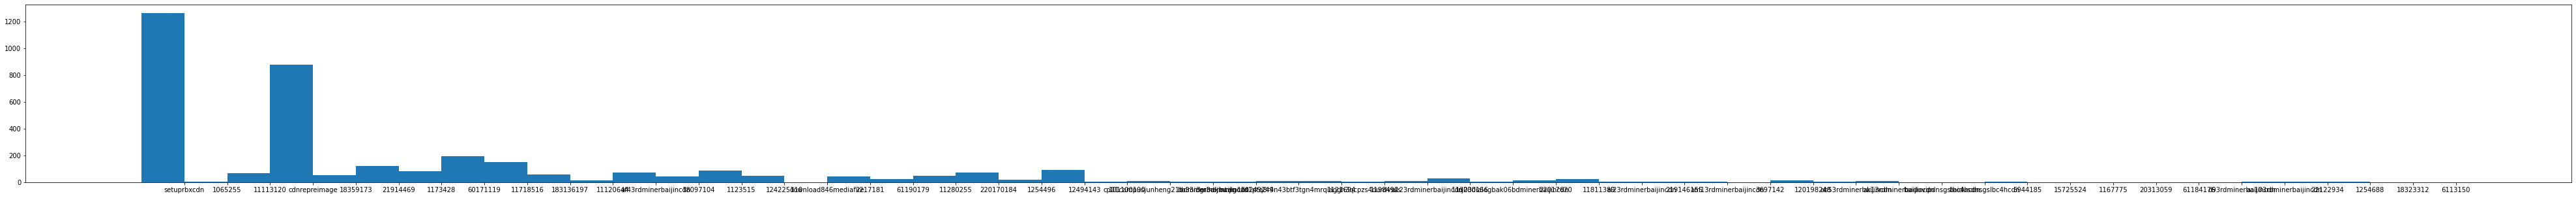

In [43]:

print("Size of train_df_clean_400_thresh : {}".format(train_df_clean_400_thresh.shape))
print_statistics_per_df(train_df_clean_400_thresh,graphs=True)

4.

In [44]:
print("Size of train_df_mal_400_thresh : {}".format(train_df_mal_400_thresh.shape))
print_statistics_per_df(train_df_mal_400_thresh)

Size of train_df_mal_400_thresh : (57249, 43)
Number of distinct file-names after pipeline : 13203
Number of distinct domain-names after pipeline : 4990
Number of distinct hostname-names after pipeline : 7991
-------------------------------------------------------
Average number of repetative file-names after pipeline : 4.336059986366735
Average number of repetative domain-names after pipeline : 11.472745490981964
Average number of repetative hostname-names after pipeline : 7.164184707796271
-------------------------------------------------------
Median number of repetative file-names after pipeline : 1
Median number of repetative domain-names after pipeline : 2.0
Median number of repetative hostname-names after pipeline : 1
-------------------------------------------------------
Average number of appearances for each file-name according to the sha1 : 1.65517459915077
Median number of appearances for each file-name according to the sha1 : 1


# **Insights:**



### **Claim:**
We noticed that the clean files came from much more frequently used domains. As you can see the average appreances for each domain name in the clean files is 515 while the average apperances for each domain name in the malicios file is only 11.
We claim that the domain of each entry in the clean subset of the train data frame is frequently used among that subset.
In order to test this claim, so we will search for each entry in the clean subset, different entries that has different sha1 and the same domain name.

In [45]:
domains_to_num_of_sha1s = print_stats_for_given_columns(train_df_clean_400_thresh)
# print("Average number of sha1s to domain-name after pipeline : {}".format(statistics.mean(domains_to_num_of_sha1s.values())))
print(domains_to_num_of_sha1s)

defaultdict(<class 'list'>, {'rbxcdn': [2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 2862513, 286251

### **Conclusion:**
The claim has derived from the division to clean and malicious, thus
the claim couldn't be fortified.

### **Claim:**
We claim that there are frequent suffixes in the malicious files. 

In [46]:
file_names_suffix_counter_mal, file_names_suffix_counter_mal_percent = check_suffix_of_files_dist(train_df_mal_400_thresh)
file_names_suffix_counter_clean, file_names_suffix_counter_clean_percent = check_suffix_of_files_dist(train_df_clean_400_thresh)
print("-----------------------------")
print(file_names_suffix_counter_mal)
print(file_names_suffix_counter_mal_percent)
print("-----------------------------")
print(file_names_suffix_counter_clean)
print(file_names_suffix_counter_clean_percent)

57249
(57249, 43)
3621
(3621, 43)
-----------------------------
Counter({'exe': 36347, 'zip': 7958, 'rar': 6365, '7z': 1202, 'themepack': 1082, 'dll': 586, 'cab': 577, 'iso': 450, 'js': 442, 'diagcab': 351, 'msi': 304, 'jar': 250, 'EXE': 233, 'apk': 213, 'deskthemepack': 125, 'hta': 123, 'xpi': 48, 'tar': 46, 'pdf': 39, 'jpg': 39, 'ipa': 39, 'ZIPd': 39, 'cmd': 31, 'gz': 27, 'htm': 19, 'CAB': 19, 'lzh': 17, 'vbs': 16, 'ZIP': 15, 'vsix': 15, 'imf': 14, 'md5': 14, 'asi': 13, 'JPG': 12, 'txt': 12, 'xls': 9, 'bz2': 8, 'tmp': 8, 'scr': 7, 'vbox-extpack': 7, 'tgz': 6, 'ISO': 5, 'RAR': 5, 'DLL': 5, 'MSI': 5, 'gadget': 4, 'bc!': 4, 'rmskin': 4, 'r03': 4, 'rbz': 4, 'chm': 4, 'aspx': 4, 'bin': 4, '婵€娲诲伐鍏_rar': 4, 'docx': 3, 'Exe': 3, 'html': 3, 'mmip': 3, 'crx': 3, 'xlsx': 2, 'msu': 2, 'DriverDownloader': 2, 'LZH': 2, 'pbiviz': 2, 'Msi': 2, '7Z': 2, 'noname': 2, 'mlc': 2, 'p7s': 2, 'efi': 2, 'com': 2, 'whl': 1, 'vdf': 1, 'solitairetheme8': 1, 'appxbundle': 1, 'nupkg': 1, '001': 1, 'Cab': 1, 'HPPS

### **Conclusion:**
The suffix 'exe' is very frequent in malicious files and therefore the 3-gram choice is the right one in order to capture that 3-gram.
In addition, 'zip' is very frequent in the malicious dataframe with ~14% of the files in the data-frame having 'zip' as suffix in contrast to the clean files which have 0%.

### **Claim:**
We claimed before that sometimes the domain (the network itself) might be non-suspicious, but a machine through this domain (the hostname) can produce a lot of malicious files.

In [47]:
train_df_mal_400_thresh.WebFileUrlHostname.value_counts()[:15]

canonicalizer.ucsuri.tcs         4432
download.microsoft.com           1600
www.chip.de                       781
github-cloud.s3.amazonaws.com     703
www.solvusoft.com                 453
cdnrep.reimage.com                451
www.towerbitscenter.com           447
www.conecptmegacenter.com         435
downloadmirror.intel.com          432
ftp.hp.com                        392
download.ap.bittorrent.com        386
subsunacs.net                     382
download.fosshub.com              368
www.sorubak.com                   353
filedelivery.nexusmods.com        332
Name: WebFileUrlHostname, dtype: int64

### **Conclusion:**
By examining the malicious data-frame we can see few domains that are very popular, such as 'microsoft' and 'amazonaws', but those files are tagged as malicious, therefore we are strengthing our claim that attackers might hide behind those machines on very popular domains.

As we know, the sha1 is hash function working on the content of the file,
so here is the histogram in order to see which files are the most frequent (maybe with different names with the same sha1) in the dataset reports.

### **Claim:**
We claim that there are file-names that are naturally suspicious,
for example, torrents, setups, drivers, etc.

In [48]:
train_df_mal_400_thresh.FileNameID.apply(pipeline_for_filename).value_counts()[:15]

setupexe                                960
utorrentexe                             617
reimagerepairexe                        450
adobeflashsetupexe                      422
idmanbuildexe                           404
inteldriverupdateutilityinstallerexe    393
vcredistxexe                            357
cheatengineexe                          335
rapidfilesidzip                         290
flashplayerproexe                       289
hpeasystartexe                          249
setupdriverdocexe                       242
chromesetupexe                          235
qbittorrentsetupexe                     221
yandexexe                               217
Name: FileNameID, dtype: int64

### **Conclusion:**
As we said above, by producing the file-names value_counts list of the malicious data-frame,
we can see that file names containing the word 'setup' and also 'driver' are very frequent.

## **Explain of one-hot encoding and tf-idf:**

1)This is sparta
2)This is garta
3)This marta

D1 - Cow , The
D2 - Dog, is, no
TF - Term Frequency.  -----> 1000
IDF - Inverse Document Frequency ---> 3 --> inverse 

Vocab - Document


cow ---> 0-1 ----> This - 0.01 , Cow - 0.99

Thi, his, isi, sis, iss, ssp, spa, part, art, rta

bsplayer_free.exe
bsplayer_pro270.1080.exe

BoW -----> Tokenize ----> "This is sparta" -> This, is, Sparta. 200,000 -> [...]


100 -> [.....] onehot vector ---> 100 [0, 1,0 ,1...] 

# **Global Features Extraction**

**Examination of ThreatFamilyID feature:**



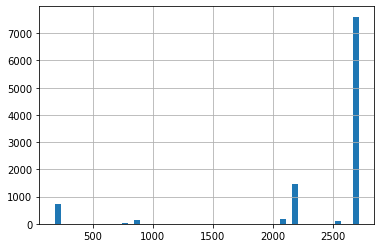

In [49]:
train_df_clean.ThreatFamilyID.hist(bins=50)


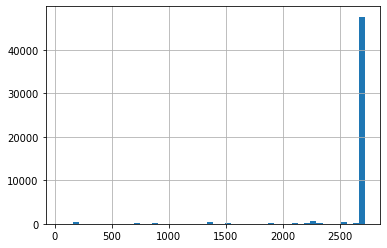

In [50]:
train_df_mal.ThreatFamilyID.hist(bins=50)

- As we can see in the graphs, most of the malicious tagged entries has ThreatFamilyID that is bigger than 2700.
Thus, we wanted to see the distribution of the sha1ID that their ThreatFamilyID
is bigger than 2700 and tagged as clean.

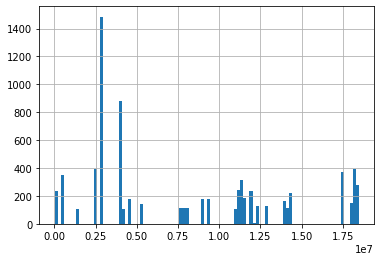

In [51]:
df_of_27xx = train_df_clean[train_df_clean.ThreatFamilyID > 2700]
df_of_27xx.Sha1ID.hist(bins=100)

As we can see, most of the files that has ThreatFamilyID > 2700 appear in the dataset with sha1ID between 100-400 (excluding extreme values)
We claim that:
- Our threshold is lower, thus there might be some files that are labeled as clean instead of malicious.

**Lets examine this claim after increasing the threshold to 400:**

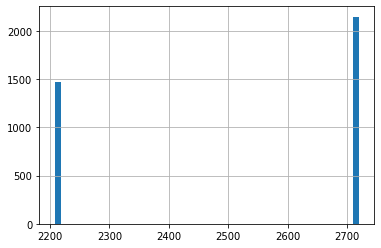

In [52]:
train_df_clean_400_thresh.ThreatFamilyID.hist(bins=50)

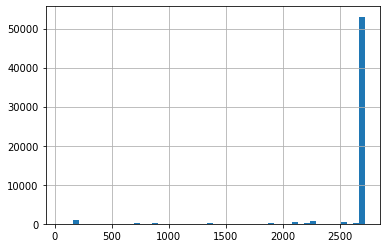

In [53]:
train_df_mal_400_thresh.ThreatFamilyID.hist(bins=50)

We can see that almost all of the malicious files (above 50K) belongs to the ThreatFamilyID that is bigger than 2700.
Even though there are still 2000+ files tagged as clean and they belong to the ThreatFamilyID that is bigger than 2700, this might be a good feature overall.

**Examination of ThreatNameID feature:**

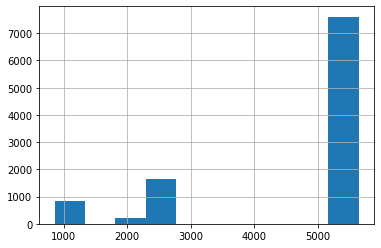

In [54]:
train_df_clean.ThreatNameID.hist()

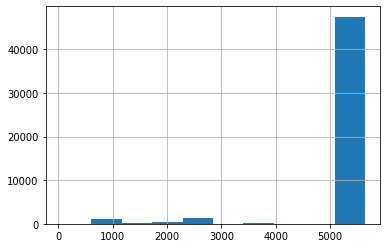

In [55]:
train_df_mal.ThreatNameID.hist()

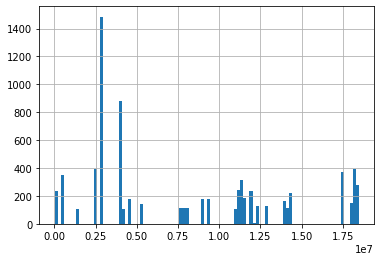

In [56]:
df_of_tn = train_df_clean[train_df_clean.ThreatNameID > 5000]
df_of_tn.Sha1ID.hist(bins=100)

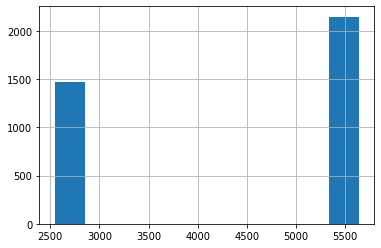

In [57]:
train_df_clean_400_thresh.ThreatNameID.hist()

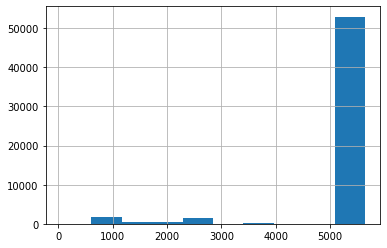

In [58]:
train_df_mal_400_thresh.ThreatNameID.hist()

##***Conclusion :*** 
The examination of ThreatNameID and ThreatFamilyID has shown us that increasing the threshold to 400, might lead to better results.

**Examination of Size feature:**


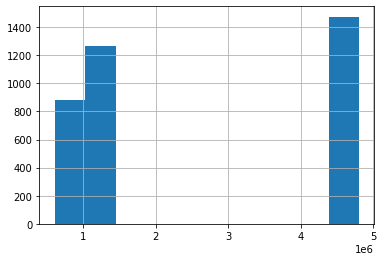

In [59]:
train_df_clean_400_thresh.Size.hist()

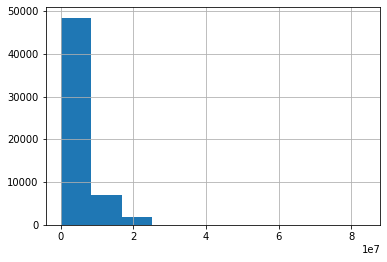

In [60]:
train_df_mal_400_thresh.Size.hist()

## **Conclusion:**
Most of the tagged malicious files in the dataset are bigger than the clean. (Assuming threshold 400)
Thus, allowing us to use this as a global feature. 

# **Machine learning**


### **Training part:**

In [61]:
_,X_train_one_hot,X_train_tf_idf,tfidf_vecs,onehot_vecs = generate_text_features_matrices(train)

------
['aaa', 'aac', 'aad', 'aae', 'aag']
------
['000', '001', '002', '00c', '00d']
------
['000', '001', '002', '003', '004']
Shapes:
one_hot_mat_for_file_name: (60870, 12260)
one_hot_mat_for_domain: (60870, 6771)
one_hot_mat_for_hostname: (60870, 13064)
------
['aaa', 'aac', 'aad', 'aae', 'aag']
------
['000', '001', '002', '00c', '00d']
------
['000', '001', '002', '003', '004']
--------
Shapes:
tfidf_mat_for_file_name: (60870, 12260)
tfidf_mat_for_domain: (60870, 6771)
tfidf_mat_for_hostname: (60870, 13064)
--------
Total shapes:
one_hot_mat_text_features: (60870, 32095)
tfidf_mat_text_features: (60870, 32095)


In [62]:
type(X_train_one_hot)

scipy.sparse.coo.coo_matrix

In [63]:
vec_for_threat_name = coo_matrix(extract_normalize_feature(train,"ThreatNameID")).reshape(-1,1)
vec_for_threat_family = coo_matrix(extract_normalize_feature(train,"ThreatFamilyID")).reshape(-1,1)
vec_for_size = coo_matrix(extract_normalize_feature(train,"Size")).reshape(-1,1)
print("Shapes:")
print("Threat-name : {}".format(vec_for_threat_name.shape))
print("Threat-family : {}".format(vec_for_threat_family.shape))
print("Size : {}".format(vec_for_size.shape))

Shapes:
Threat-name : (60870, 1)
Threat-family : (60870, 1)
Size : (60870, 1)


In [64]:
X_train_one_hot = hstack([X_train_one_hot,vec_for_threat_name,vec_for_threat_family,vec_for_size])
X_train_tf_idf = hstack([X_train_tf_idf,vec_for_threat_name,vec_for_threat_family,vec_for_size])
Y_train_400_thresh = np.asarray(Y_train_400_thresh)


print("Matrices final shape:")
print("X_train_one_hot : {}".format(X_train_one_hot.shape))
print("X_train_tf_idf : {}".format(X_train_tf_idf.shape))
print("Y_train_400_thresh : {}".format(Y_train_400_thresh.shape))

Matrices final shape:
X_train_one_hot : (60870, 32098)
X_train_tf_idf : (60870, 32098)
Y_train_400_thresh : (60870,)


We use **F1 score** because the distribution of the clean and malicious files within the data-set is imbalanced, thus we want to evaluate the model according to the it's false predicitions.

- False Positive: The model predicted it is a malicious it is clean.
- False Negative: The model predicted it is a clean and it is malicious.

In [0]:
scoring = ['precision', 'recall','accuracy','f1']

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn import svm

def train(X,Y,kernel='rbf',deg=3):
  clf = svm.SVC(kernel=kernel,degree=deg, C=1, gamma='scale')
  scores = cross_validate(clf, X, Y, scoring=scoring,return_estimator=True,)
  sorted(scores.keys())
  return scores


In [0]:
cv_one_hot_scores_rbf = train(X_train_one_hot,Y_train_400_thresh)


In [0]:
# cv_one_hot_scores_poly = train(X_train_one_hot,Y_train_400_thresh,kernel='poly',deg=4)


In [0]:
cv_one_hot_scores_linear = train(X_train_one_hot,Y_train_400_thresh,kernel='linear')

In [0]:
cv_tfidf_scores_rbf = train(X_train_tf_idf,Y_train_400_thresh)


In [0]:
# cv_tfidf_scores_poly = train(X_train_tf_idf,Y_train_400_thresh,kernel='poly',deg=4)

In [0]:
cv_tfidf_scores_linear = train(X_train_tf_idf,Y_train_400_thresh,kernel='linear')

In [73]:
cv_tfidf_scores_linear

{'estimator': (SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
      max_iter=-1, probability=False, random_state=No

In [0]:
def extract_best_model(scores):
  max_f1_score = max(scores["test_f1"])
  best_idx = list(scores["test_f1"]).index(max_f1_score)
  print(best_idx)
  best_model = scores["estimator"][best_idx]
  return best_model,max_f1_score

In [75]:
models_obj = [cv_one_hot_scores_rbf,cv_one_hot_scores_linear,cv_tfidf_scores_rbf,cv_tfidf_scores_linear]
models_obj = [extract_best_model(x) for x in models_obj]
print(models_obj)


3
3
3
3
[(SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.996450948604478), (SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.9964949176305643), (SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 0.9964946104635877), (SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probabil

# **Best model:**

In [76]:
best_model = max(models_obj,key=lambda x:x[1])
print(best_model[0])
print("Training F1_Score of {}".format(best_model[1]))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training F1_Score of 0.9964949176305643


### The best model that was chosen, was the SVC with C=1 (SVM)
### Linear kernel, trained on one-hot vectors!

# **Test and evaluation part:**

Extracting the global features for each entry in the test set

In [84]:
test_vec_for_threat_name = coo_matrix(extract_normalize_feature(test,"ThreatNameID")).reshape(-1,1)
test_vec_for_threat_family = coo_matrix(extract_normalize_feature(test,"ThreatFamilyID")).reshape(-1,1)
test_vec_for_size = coo_matrix(extract_normalize_feature(test,"Size")).reshape(-1,1)

print("test_vec_for_threat_name shape: {}".format(test_vec_for_threat_name.shape))
print("test_vec_for_threat_family shape: {}".format(test_vec_for_threat_family.shape))
print("test_vec_for_size shape: {}".format(test_vec_for_size.shape))


test_vec_for_threat_name shape: (15218, 1)
test_vec_for_threat_family shape: (15218, 1)
test_vec_for_size shape: (15218, 1)


In [85]:
def convert_col_in_df_to_mat(df,vectorizer,col,rep_nans=False,pipe=None):
  list_of_vals = replace_nans([x for x in df[col]])
  list_of_vals = [pipe(x) if pipe else x for x in list_of_vals]
  X = vectorizer.transform(list_of_vals)
  return X

def transform_df_to_mat(df,vecs,cols,pipe=None):
  list_of_mats = []
  for vec,col in zip(vecs,cols):
    list_of_mats.append(convert_col_in_df_to_mat(df,vec,col,pipe=pipe))
  return hstack(list_of_mats)

cols = ['FileNameID','WebFileUrlDomain','WebFileUrlHostname']

X_test_one_hot_file_name = convert_col_in_df_to_mat(test,onehot_vecs["fn"],cols[0],pipe=pipeline_for_filename)
X_test_one_hot_domain_name = convert_col_in_df_to_mat(test,onehot_vecs["dn"],cols[1],rep_nans=True,pipe=pipeline_for_domain)
X_test_one_hot_hostname_name = convert_col_in_df_to_mat(test,onehot_vecs["hn"],cols[2],rep_nans=True,pipe=pipeline_for_hostname)

list_test_one_hot = [X_test_one_hot_file_name,X_test_one_hot_domain_name,X_test_one_hot_hostname_name]
test_one_hot = hstack(list_test_one_hot)


X_test_tfidf_file_name = convert_col_in_df_to_mat(test,tfidf_vecs["fn"],cols[0],pipe=pipeline_for_filename)
X_test_tfidf_domain_name = convert_col_in_df_to_mat(test,tfidf_vecs["dn"],cols[1],rep_nans=True,pipe=pipeline_for_domain)
X_test_tfidf_hostname_name = convert_col_in_df_to_mat(test,tfidf_vecs["hn"],cols[2],rep_nans=True,pipe=pipeline_for_hostname)

list_test_tf_idf = [X_test_tfidf_file_name,X_test_tfidf_domain_name,X_test_tfidf_hostname_name]
test_tf_idf = hstack(list_test_tf_idf)


test_one_hot = hstack([test_one_hot,test_vec_for_threat_name,test_vec_for_threat_family,test_vec_for_size])
test_tf_idf = hstack([test_tf_idf,test_vec_for_threat_name,test_vec_for_threat_family,test_vec_for_size])
Y_test_400_thresh = np.asarray(Y_test_400_thresh)



print("test_one_hot shapes : {}".format(test_one_hot.shape))
print("test_tf_idf shapes : {}".format(test_tf_idf.shape))
print("Y_test_400_thresh: {}".format(Y_test_400_thresh.shape))
#TODO: 
# 1. Select the best model from above.
# 2. Asses the test-set.
  

test_one_hot shapes : (15218, 32098)
test_tf_idf shapes : (15218, 32098)
Y_test_400_thresh: (15218,)


In [0]:
model = best_model[0]

In [0]:
acc_test = model.score(test_one_hot,Y_test_400_thresh)

In [90]:
y_pred_test_one_hot = model.predict(test_one_hot)
y_pred_test_tf_idf = model.predict(test_tf_idf)

print("y_pred_test_one_hot shape: {}".format(y_pred_test_one_hot.shape))
print("y_pred_test_tf_idf shape: {}".format(y_pred_test_tf_idf.shape))

y_pred_test_one_hot shape: (15218,)
y_pred_test_tf_idf shape: (15218,)


In [93]:
print(y_pred_test_one_hot[:10])
print("-------")
print(Y_test_400_thresh[:10])

[1 1 1 1 1 1 1 1 1 1]
-------
[0 0 1 1 1 1 1 1 1 1]


In [99]:
from sklearn.metrics import precision_recall_fscore_support

tup1 = precision_recall_fscore_support(Y_test_400_thresh, y_pred_test_one_hot, average='binary')
tup2 = precision_recall_fscore_support(Y_test_400_thresh, y_pred_test_tf_idf, average='binary')

print("one_hot_f1_score Precision: {} Recall: {} F1_Score: {}".format(tup1[0],tup1[1],tup1[2]))

print("tf_idf_f1_score Precision: {} Recall: {} F1_Score: {}".format(tup2[0],tup2[1],tup2[2]))

one_hot_f1_score Precision: 0.9436325678496869 Recall: 0.9999286376935702 F1_Score: 0.9709652830711663
tf_idf_f1_score Precision: 0.920817453016165 Recall: 1.0 F1_Score: 0.9587766412370429


# Conclusion:
- As we can see our recall is high and the precision is abit lower.
- Due to high recall rate, we can conclude that our false positives are very low on the test set, which means we barely make mistakes on malicious files.
- Due to lower precision rate with respect to recall, we can conclude that
most of the times the model rather classify a file as malicious than clean, which is
settled with reality.